In [498]:
import numpy as np
import seaborn as sns
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import collections

# Task 1

In [474]:
def createGraph(df):
    G = nx.DiGraph() # Using a directed graph as told in the question
    countries = df['name'].tolist()
    G.add_nodes_from(countries)
    # Add edges based on the atlas condition
    for country1 in countries:
        for country2 in countries:
            if country1 != country2 and country1[-1].lower() == country2[0].lower():
                G.add_edge(country1, country2)
    return G

In [475]:
def plotGraph(G,graph_name):
    degrees = dict(G.degree())
    node_colors = [degrees[node] for node in G.nodes()]
    
    # Normalize the node colors for colormap
    norm = mcolors.Normalize(vmin=min(node_colors), vmax=max(node_colors))
    cmap = cm.autumn
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(30, 30))
    pos = nx.kamada_kawai_layout(G)
    
    # Draw nodes and edges with color mapping
    nodes = nx.draw_networkx_nodes(
        G, pos, ax=ax, node_size=50, node_color=node_colors, cmap=cmap
    )
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.3, edge_color='gray')
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=5, font_color='black', font_weight='bold')
    
    # Create a ScalarMappable and add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Degree')
    
    # Show the plot
    plt.axis('off') # I dont want x-axis and y-axis to be present
    plt.savefig(f"{graph_name}.png",dpi=300)
    plt.show()
    return pos # documentation says this is optimised

## Countries:

In [ ]:
df = pd.read_csv('CSV/Used/cities.csv', usecols=['name'])
G = createGraph(df)

In [ ]:
pos = plotGraph(G,"cities")

### Initial Ideas for analysis

In [ ]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Sort nodes by in-degree in descending order
sorted_by_in_degree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)

# Calculate the maximum width needed for the node column based on the longest node name
max_node_width = max(len(node) for node in in_degrees.keys())

# Define the header with dynamically calculated widths
header = f"{'Node':<{max_node_width}} | {'In-Degree':<10} | {'Out-Degree':<10}"
separator = '-' * len(header)

# Print the header
print(header)
print(separator)

# Print each row with aligned columns using the calculated width
for node, in_degree in sorted_by_in_degree:
    out_degree = out_degrees[node]
    print(f"{node:<{max_node_width}} | {in_degree:<10} | {out_degree:<10}")


##### Insight
Once game starts, the nodes with in-degree 0 become irrelevant, ie, after the first move, all of the nodes with indegree 0 can be removed. (apparently called graph pruning :didnt know about it while doing this)

The idea is that we need to find countries such that their outdegree is 0. If we find this then we can backtrack paths to reach the starting node  
This way we can find a way to trap our opponent in the game (apparently called retrograde analysis: didnt know about it when I was doing this task)

In [ ]:
# Sort nodes by out-degree in descending order
sorted_by_out_degree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)

# Calculate the maximum width needed for the node column based on the longest node name
max_node_width = max(len(node) for node in out_degrees.keys())

# Print the header
print(header) # defined from earlier
print(separator) #defined from earlier

# Print each row with aligned columns using the calculated width
for node, out_degree in sorted_by_out_degree:
    in_degree = in_degrees[node]
    print(f"{node:<{max_node_width}} | {in_degree:<10} | {out_degree:<10}")


We notice that there exists no node with 0 outgoing edges, which means our task isnt as simple as just getting to that node.

### Centrality and degree analysis:

#### Intent:
4 types of centrality measures, will try out all to see if i can find out insights

#### Degree Centrality: 

Initially, I was using scatter plot with node indices. Soon, I realised that that is probably not the best way to visualise this because of the node indices not really holding much value(artificial construction of ours). That is why I added histograms instead.

In [140]:
def plot_hist_indeg_outdeg_separate(G,in_degree_centrality,out_degree_centrality): # G is a digraph

    # Generate normalized indices for scatter plots - normalised between 0 and 1
    node_indices = np.linspace(0, 1, len(in_degree_centrality))
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    
    # Histogram for In-Degree Centrality
    ax[0].hist(in_degree_centrality.values(), bins=20, color='blue', alpha=0.7, edgecolor='black')
    ax[0].set_xlabel("In-Degree Centrality")
    ax[0].set_ylabel("Frequency")
    ax[0].set_title("Histogram of In-Degree Centrality")
    
    # Histogram for Out-Degree Centrality
    ax[1].hist(out_degree_centrality.values(), bins=20, color='red', alpha=0.7, edgecolor='black')
    ax[1].set_xlabel("Out-Degree Centrality")
    ax[1].set_ylabel("Frequency")
    ax[1].set_title("Histogram of Out-Degree Centrality")
    
    plt.tight_layout()
    plt.show()


In [141]:
def plot_hist_pdf_combined(G,in_degree_centrality,out_degree_centrality):
    # Create subplots
    in_degree_centrality = np.array(list(in_degree_centrality.values()))
    out_degree_centrality = np.array(list(out_degree_centrality.values()))
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histogram (left subplot)
    axes[0].hist(in_degree_centrality, bins=20, color='blue', alpha=0.6, edgecolor='black', label='In-Degree Centrality')
    axes[0].hist(out_degree_centrality, bins=20, color='red', alpha=0.6, edgecolor='black', label='Out-Degree Centrality')
    axes[0].set_xlabel("Centrality Value")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Histogram of In-Degree and Out-Degree Centrality")
    axes[0].legend()
    axes[0].grid()
    
    # PDF (right subplot)
    sns.kdeplot(in_degree_centrality, bw_adjust=0.5, fill=True, color="blue", label="In-Degree Centrality", ax=axes[1])
    sns.kdeplot(out_degree_centrality, bw_adjust=0.5, fill=True, color="red", label="Out-Degree Centrality", ax=axes[1])
    axes[1].set_xlabel("Centrality Value")
    axes[1].set_ylabel("Density")
    axes[1].set_title("PDF of In-Degree and Out-Degree Centrality")
    axes[1].legend()
    axes[1].grid()
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


In [142]:
idc = nx.in_degree_centrality(G)
odc = nx.out_degree_centrality(G)

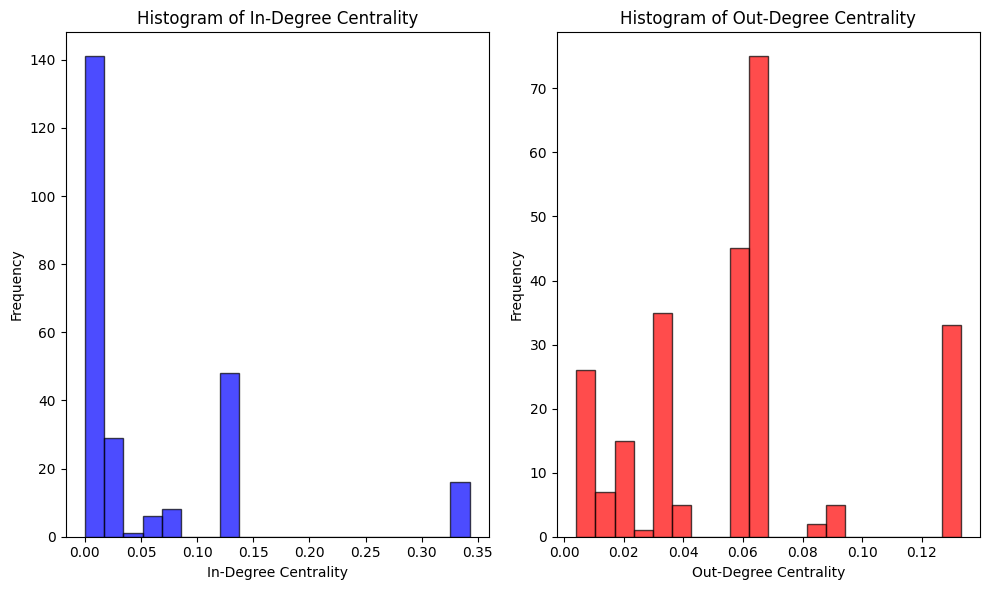

In [143]:
plot_hist_indeg_outdeg_separate(G,idc,odc)

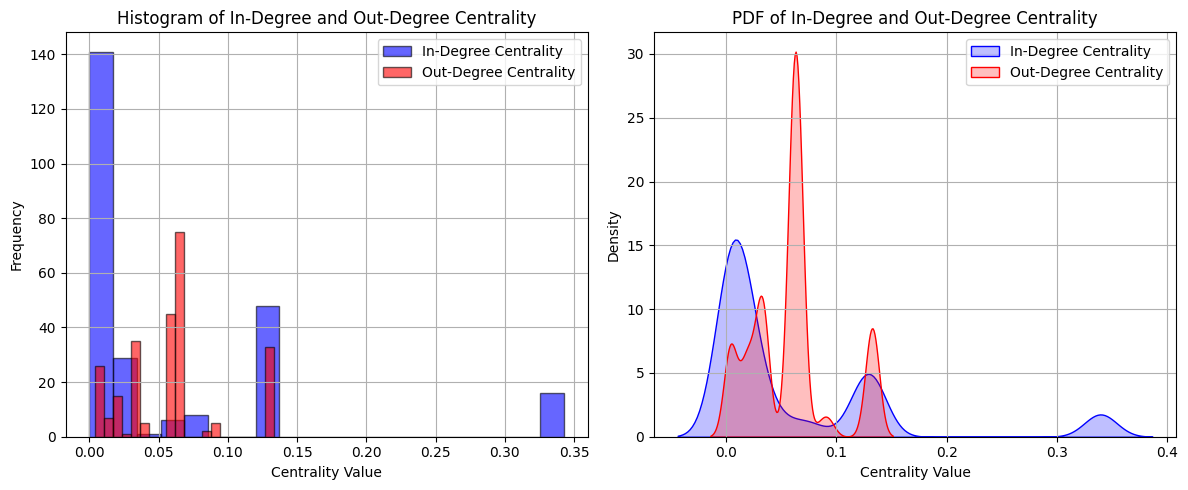

In [144]:
plot_hist_pdf_combined(G,idc,odc)

##### Analysis:
The distributions are highly right-skewed where most nodes have low centrality values(network is relatively sparse), but there is a presence of hubs nodes(especially in the in-degree distribtion) that has much higher values.  
These hub nodes would probably be critical in connectivity of the graph.
Another note to myself: could try outlier and fat tail analysis, and I could try to identify the highest degree nodes, and do analysis on remaining nodes' degree distribution in case they were removed (trying to break the atlas network with extranneous rules)

In [145]:
def plot_indeg_v_outdeg(G,in_deg_centrality,out_deg_centrality):
    # Create lists of centrality values in the same order of nodes
    nodes = list(G.nodes())
    in_values = [in_deg_centrality[node] for node in nodes]
    out_values = [out_deg_centrality[node] for node in nodes]
    
    # Plot the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(in_values, out_values, color='purple', alpha=0.7)
    plt.xlabel("In-Degree Centrality")
    plt.ylabel("Out-Degree Centrality")
    plt.title("Scatter Plot of In-Degree vs. Out-Degree Centrality")
    plt.grid(True)
    plt.show()

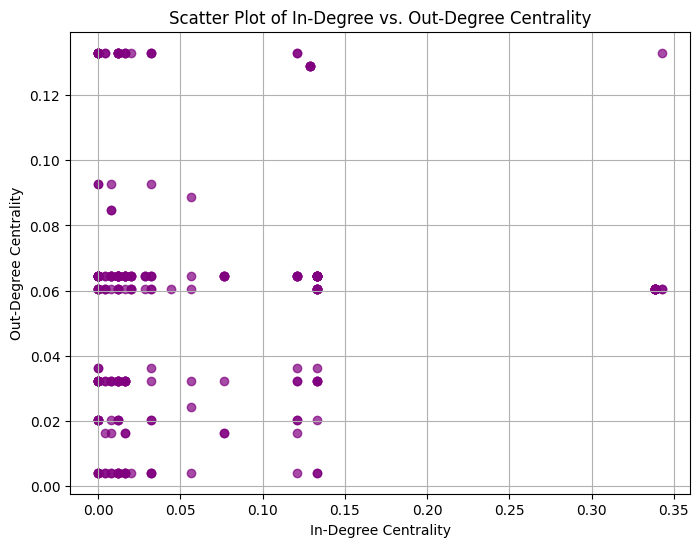

In [146]:
plot_indeg_v_outdeg(G,idc,odc)

##### Analysis:
Since, we want a strategic advantage, we could target those nodes that have lower outdegree, and higher indegree  
Low outdegree means that the opponent can possibly get trapped there.  
High indegree means that the possiblity of us getting there is more.  
So, in essence, we can think of choosing lower right nodes in the above scatter plot as advantageous. In some sense, any node with y-axis value closer to the axis itself is advantageous(low outdegree) but there are higher chances of getting ones as we move right on the x-axis

##### Other centrality measures:

In [451]:
betweenness_centrality = nx.betweenness_centrality(G)

# Top 5 bridge nodes
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by betweenness centrality:", top_betweenness)

Top 5 nodes by betweenness centrality: [('Aland Islands', 0.10831349606816493), ('Nauru', 0.09953600917098368), ('Dominican Republic', 0.09779491636452586), ('United Kingdom', 0.08715344502695944), ('Afghanistan', 0.07585639224009344)]


In [84]:
closeness_centrality = nx.closeness_centrality(G)

# Top 5 nodes with best reachability
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by closeness centrality:", top_closeness)


Top 5 nodes by closeness centrality: [('Afghanistan', 0.5662100456621004), ('Aland Islands', 0.5662100456621004), ('Azerbaijan', 0.5662100456621004), ('Albania', 0.5649202733485194), ('Algeria', 0.5649202733485194)]


In [87]:
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# Top 5 influential nodes
top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by eigenvector centrality:", top_eigenvector)


Top 5 nodes by eigenvector centrality: [('Afghanistan', 0.252396726424517), ('Aland Islands', 0.252396726424517), ('Azerbaijan', 0.252396726424517), ('Albania', 0.23720532360922214), ('Algeria', 0.23720532360922214)]


##### Analysis:
High betweenness nodes can be both advantageous (to access many parts of the graph) and risky (bottlenecks that can limit options once opponent uses it).  
High closeness between nodes means that these are typically safe because they can access easily most of the graph.  
Eigenvector closeness takes more advantage to those nodes that are connected to hubs, for better strategising safe nodes than high closeness. We see however, that top 5 nodes in closeness and eigenvector are same.  

### Strongly connected components, diameter:

#### Intent
Strongly connected components are extremely useful for understanding back and forth connectivity, and finding out nodes that might trap the other person, having very low strong connections

In [478]:
sccs = list(nx.strongly_connected_components(G))
sccs_sorted = sorted(sccs, key=len, reverse=True)
scc_sizes = np.array([len(scc) for scc in sccs_sorted])
print(f"Total SCCs: {len(sccs_sorted)}")

Total SCCs: 59


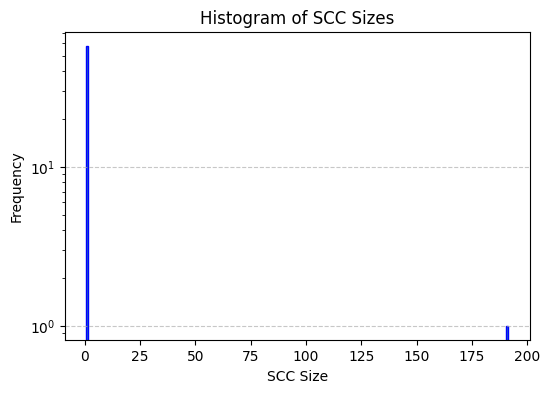

In [480]:
plt.figure(figsize=(6, 4))
plt.hist(scc_sizes, bins=np.arange(1, scc_sizes.max() + 2) - 0.5, edgecolor="blue")
plt.xlabel("SCC Size")
plt.ylabel("Frequency")
plt.title("Histogram of SCC Sizes")
plt.yscale("log")  # Use log scale if there's a large difference in SCC counts
plt.grid(axis="y", linestyle="--", alpha=0.7)

#### Analysis
Large SCC (191 nodes) indicates a large, highly interconnected subgraph where players can cycle between places before being forced out.
It suggests that most places in the game are part of a core region with multiple valid transitions.  
Isolated nodes (58 SCCs of size 1): These are dangerous dead-end places with limited options for the player.

In [481]:
def plot_low_sccs(G, sccs):
    largest_scc = max(sccs, key=len)
    non_dominant_nodes = set(G.nodes) - largest_scc
    non_dominant_subgraph = G.subgraph(non_dominant_nodes) # Create subgraph of non-dominant SCC nodes

    plt.figure(figsize=(12, 5))
    nx.draw(non_dominant_subgraph, nx.layout.fruchterman_reingold_layout(G), with_labels=True, node_size=10, font_size=9, node_color="cyan", edge_color="gray")
    plt.title("Graph of Nodes Not in the Largest SCC")
    plt.show()

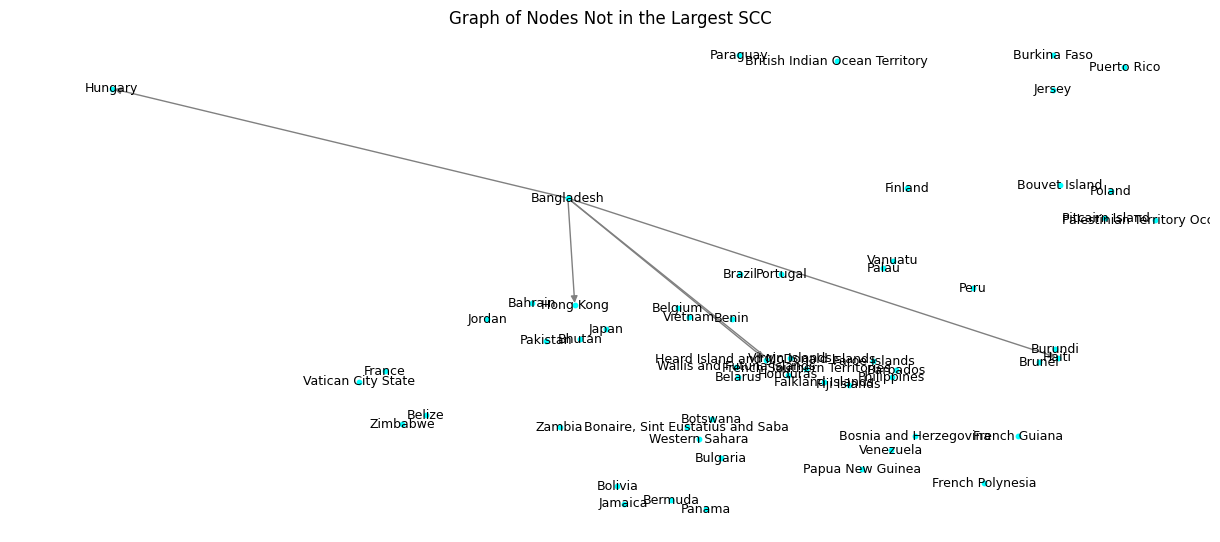

In [482]:
plot_low_sccs(G,sccs)

#### Analysis:
Typically from the graph, we can see that most of them start with letters which have countries of 0 indegree. This means, that most likely, we shall end up in the dominant SCC

In [486]:
def get_diam(G,sccs):
    largest_scc = max(sccs, key=len)
    dom_scc = G.subgraph(largest_scc)
    diameter = nx.diameter(dom_scc)
    print(f"Graph Diameter: {diameter}")

In [487]:
get_diam(G,sccs)

Graph Diameter: 5


#### Analysis:

The diameter tells how far the furthest location is in the game. A diameter of 5 means that, in the worst case, any two places (nodes) in the game can be connected by a sequence of at most five moves. This low diameter is characteristic of a **small-world network** where nodes are tightly linked. In practice, it implies that even if you start from a less-connected or peripheral location, you’re never more than five moves away from any other place in the game, unless the game has actually progressed a lot.  

### Articulation Points:

#### Intent
Finding vulnerabilites in network, or critical nodes that cut the graph in some sense

In [328]:
cut_vertices = list(nx.articulation_points(G.to_undirected()))
print(f"Critical nodes whose removal disconnects the graph: {cut_vertices}")

Critical nodes whose removal disconnects the graph: ['Yemen', 'Oman']


#### Analysis:
This is less useful because done on undirected Graph, but still has some use in identifying nodes of importance

In [332]:
def strong_articulation_points(G):
    original_scc_count = nx.number_strongly_connected_components(G)
    cut_vertices = []

    for node in G.nodes:
        G_copy = G.copy()
        G_copy.remove_node(node)
        new_scc_count = nx.number_strongly_connected_components(G_copy)
        
        if new_scc_count > original_scc_count:
            cut_vertices.append(node)

    print(f"Strong articulation points (critical nodes in directed graph): {cut_vertices}")
    return cut_vertices


In [333]:
cut_vertices=strong_articulation_points(G)

Strong articulation points (critical nodes in directed graph): ['Denmark', 'Dominican Republic', 'Iraq', 'Luxembourg', 'Oman', 'Qatar', 'Yemen']


In [490]:
# Create a subgraph without the strong articulation points
G_sub = G.copy()
G_sub.remove_nodes_from(cut_vertices)
print(f"Initial graph was with {len(G.nodes)} nodes and {len(G.edges)} edges (including cut vertices).")
print(f"Subgraph created with {len(G_sub.nodes)} nodes and {len(G_sub.edges)} edges (excluding cut vertices).")

Initial graph was with 249 nodes and 3575 edges (including cut vertices).
Subgraph created with 242 nodes and 3431 edges (excluding cut vertices).


#### Analysis:
These represent major points to control the game, once this has been used up by either person, the game's space size reduces considerably

### Random Walks:

#### Intent:

I wanted to do analysis based on random walks because random walks without repeats just mean an iteration of the game in itself.

In [491]:
def random_walk(G, start_node, steps=10,print_bool = True):
    if start_node not in G:
        print(f"Node {start_node} is not in the graph.")
        return None

    path = [start_node]
    current = start_node

    for _ in range(steps):
        successors = list(set(G.successors(current)) - set(path))  # Remove visited nodes
        if not successors:
            break  # Stop if no unvisited successors are left
        current = np.random.choice(successors)
        path.append(current)
    if(print_bool):
        print(f"Random walk from {start_node} ({steps} steps max, no repeats):")
        print(" → ".join(map(str, path)))

    return path


In [492]:
walk_path = random_walk(G,"Yemen",500) # done to make sure it stops on its own
subgraph_edges = [(walk_path[i], walk_path[i + 1]) for i in range(len(walk_path) - 1)]
G_sub = G.edge_subgraph(subgraph_edges).copy()

Random walk from Yemen (500 steps max, no repeats):
Yemen → Northern Mariana Islands → Saint-Martin → Norfolk Island → Dominican Republic → Cameroon → Nepal → Latvia → Armenia → Aruba → Albania → Afghanistan → Norway


In [493]:
def plot_subgraph(G_sub,pos):
    if not G_sub:
        print("No subgraph to plot.")
        return

    plt.figure(figsize=(8, 6))
    # pos = nx.kamada_kawai_layout(G_sub)  # Positioning nodes
    nx.draw(G_sub, pos, with_labels=True, node_color="skyblue", edge_color="gray", 
            node_size=500, font_size=10, arrows=True)
    
    plt.title("Random Walk Subgraph")
    plt.show()

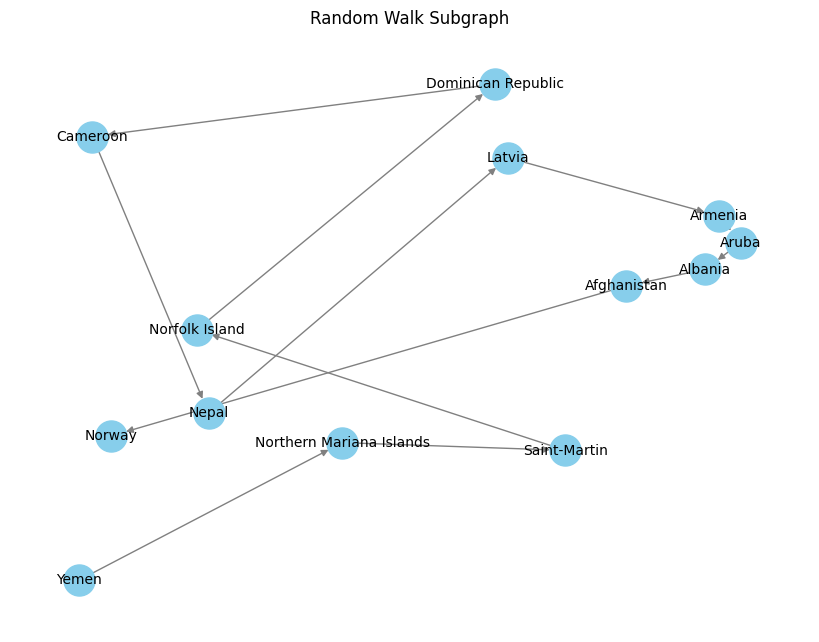

In [494]:
plot_subgraph(G_sub,pos)

#### Analysis
Extremely useful because by running it again and again, i can get real game simulations. Will do further statistics on this.

### Walk statistics:

In [495]:
def analyze_walks(all_walks):
    walk_lengths = [len(walk) for walk in all_walks]
    unique_nodes = set(node for walk in all_walks for node in walk)

    print(f"Total walks simulated: {len(all_walks)}")
    print(f"Average walk length: {np.mean(walk_lengths):.2f}")
    print(f"Max walk length: {np.max(walk_lengths)}")
    print(f"Min walk length: {np.min(walk_lengths)}")
    print(f"Total unique nodes visited across walks: {len(unique_nodes)}")


In [496]:
def run_multiple_walks(G, start_node, steps=10, num_walks=500):
    all_walks = [random_walk(G, start_node, steps,print_bool=False) for _ in range(num_walks)]
    all_walks = [walk for walk in all_walks if walk]  # Remove empty walks

    return all_walks


In [499]:
def plot_walk_frequency(all_walks):
    node_counts = collections.Counter(node for walk in all_walks for node in walk)
    
    most_common = node_counts.most_common(20)  # Top 20 visited nodes
    nodes, counts = zip(*most_common)

    plt.figure(figsize=(10, 5))
    plt.barh(nodes, counts, color="steelblue")
    plt.xlabel("Visit Frequency")
    plt.ylabel("Node")
    plt.title("Top 20 Most Frequently Visited Nodes")
    plt.gca().invert_yaxis()  # Highest on top
    plt.show()


Total walks simulated: 500
Average walk length: 24.58
Max walk length: 36
Min walk length: 6
Total unique nodes visited across walks: 169


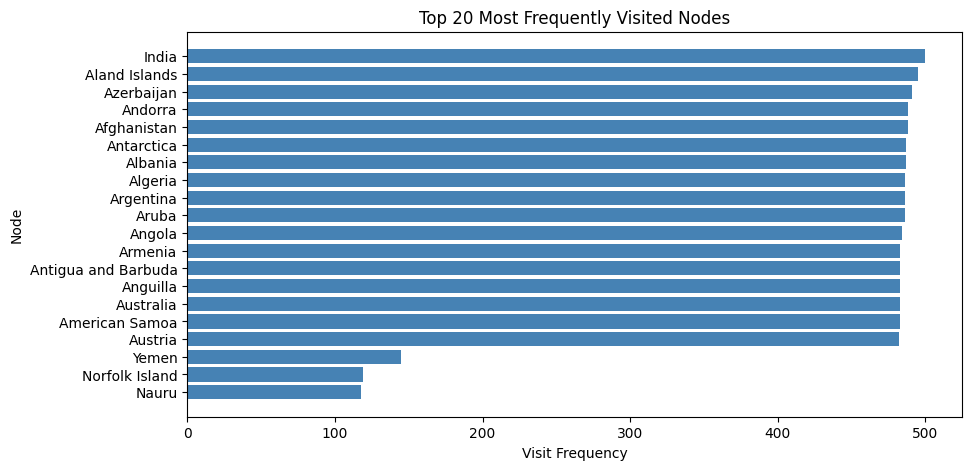

In [501]:
start_node = "India"
all_walks = run_multiple_walks(G, start_node, steps=500, num_walks=500)

analyze_walks(all_walks)
plot_walk_frequency(all_walks)

#### Analysis: 
From the various things we have seen so far, A starting nodes seem to have huge visiting frequency, considering nodes that end with A safe.  
Also, will do an analysis on many possible walks for each node as startnode.

In [509]:
def analyze_all_walks(G, steps=500, num_walks=500):
    """
    Typical data analysis function
    """

    # Local helper function: Compute metrics from a list of walks.
    def compute_walk_metrics(all_walks):
        walk_lengths = [len(walk) for walk in all_walks]
        unique_nodes = set(node for walk in all_walks for node in walk)
        return {
            'total_walks': len(all_walks),
            'avg_length': np.mean(walk_lengths),
            'max_length': np.max(walk_lengths),
            'min_length': np.min(walk_lengths),
            'unique_nodes': len(unique_nodes)
        }
    
    # Aggregate metrics for each starting node.
    node_metrics = {}
    for node in G.nodes():
        all_walks = run_multiple_walks(G, node, steps, num_walks)
        metrics = compute_walk_metrics(all_walks)
        node_metrics[node] = metrics

    # Convert the aggregated metrics to a DataFrame.
    df_metrics = pd.DataFrame.from_dict(node_metrics, orient='index')
    print("Summary statistics of walk metrics:")
    print(df_metrics.describe())

    # --- Visualization Section ---
    sns.set(style="whitegrid")
    
    # 1. Histogram of Average Walk Lengths
    plt.figure(figsize=(10, 6))
    sns.histplot(df_metrics['avg_length'], bins=20, kde=True, color='skyblue')
    plt.xlabel("Average Walk Length")
    plt.ylabel("Frequency")
    plt.title("Histogram of Average Walk Lengths per Starting Node")
    plt.show()

    # 2. Histogram of Unique Nodes Visited
    plt.figure(figsize=(10, 6))
    sns.histplot(df_metrics['unique_nodes'], bins=20, kde=True, color='lightgreen')
    plt.xlabel("Unique Nodes Visited")
    plt.ylabel("Frequency")
    plt.title("Histogram of Unique Nodes Visited per Starting Node")
    plt.show()

    # 3. Scatter Plot: Average Walk Length vs. Unique Nodes Visited
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_metrics, x='avg_length', y='unique_nodes',
                    size='max_length', hue='min_length', palette='viridis', sizes=(50, 300))
    plt.xlabel("Average Walk Length")
    plt.ylabel("Unique Nodes Visited")
    plt.title("Avg Walk Length vs. Unique Nodes Visited per Starting Node")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    # 4. Boxplots of the Walk Metrics
    plt.figure(figsize=(12, 8))
    df_metrics[['avg_length', 'max_length', 'min_length', 'unique_nodes']].boxplot()
    plt.title("Boxplots of Walk Metrics Across Starting Nodes")
    plt.xticks(rotation=45)
    plt.show()

    # Return the DataFrame for further analysis if needed.
    return df_metrics


Summary statistics of walk metrics:
       total_walks  avg_length  max_length  min_length  unique_nodes
count        249.0  249.000000  249.000000  249.000000    249.000000
mean         500.0   25.413422   40.024096    5.979920    175.144578
std            0.0    1.368961    2.429536    2.044761      5.155171
min          500.0   21.230000   34.000000    2.000000    161.000000
25%          500.0   24.548000   38.000000    4.000000    172.000000
50%          500.0   26.080000   40.000000    5.000000    174.000000
75%          500.0   26.568000   42.000000    7.000000    178.000000
max          500.0   27.218000   48.000000   12.000000    189.000000


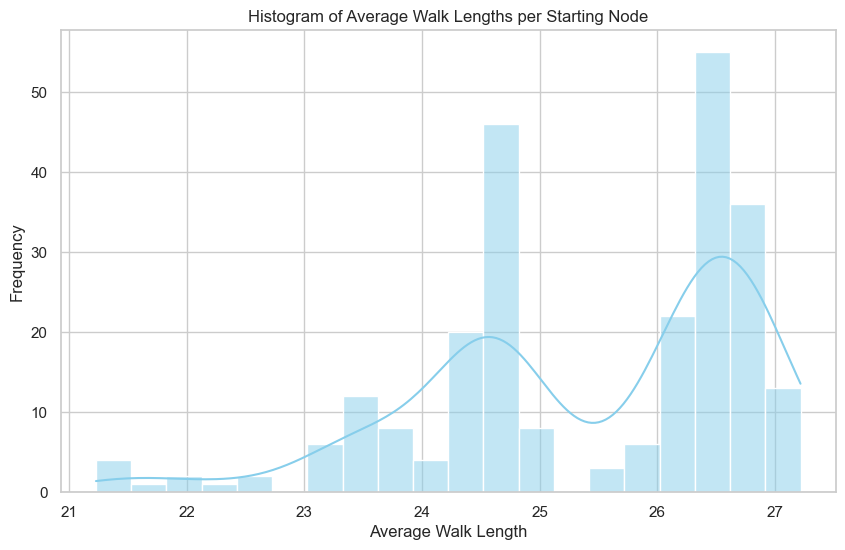

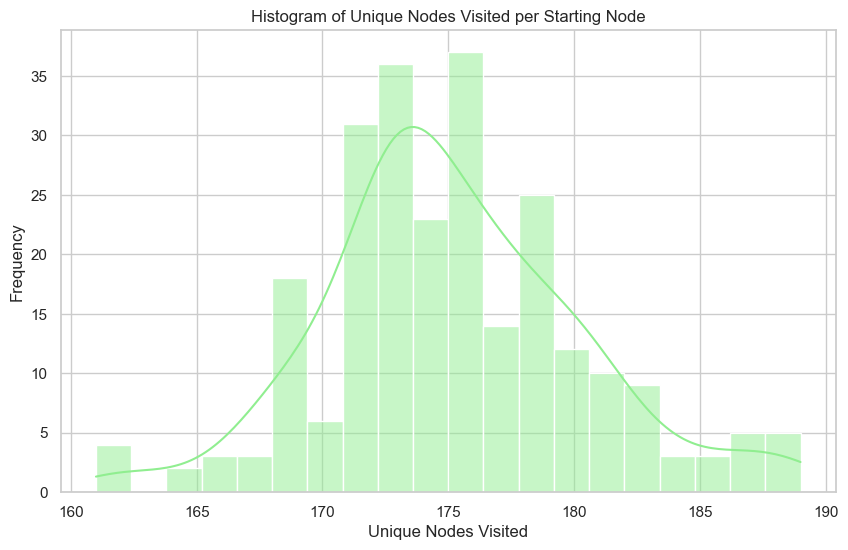

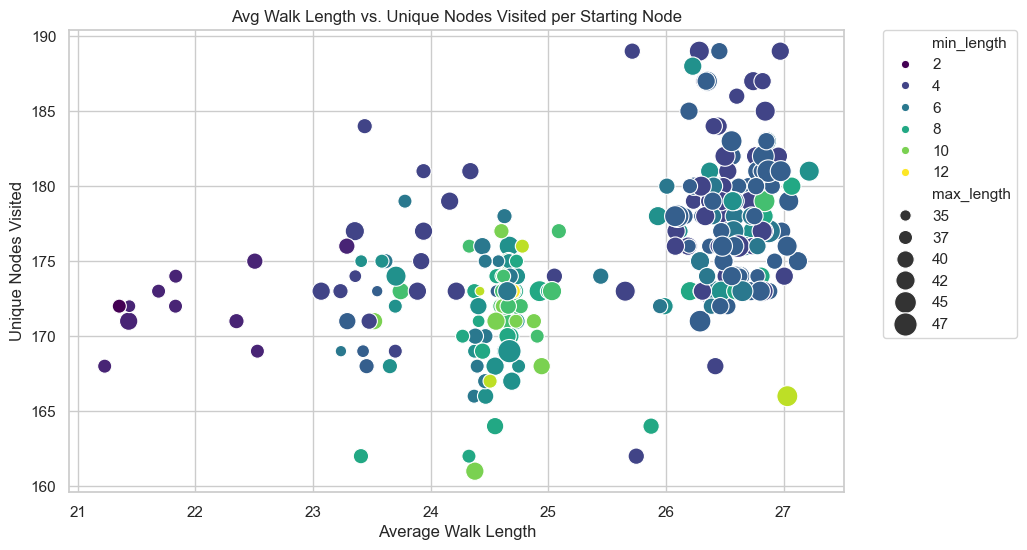

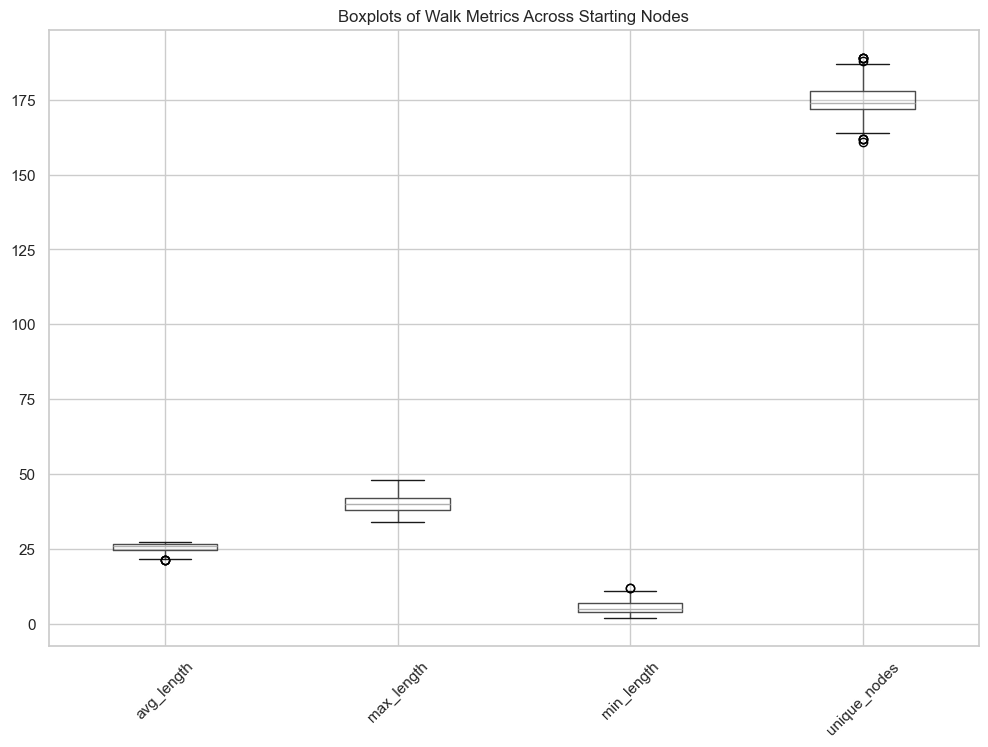

In [507]:
df_m = analyze_all_walks(G)

#### Analysis:
avg_length mean is 25.4, which means most games end in 25 moves.  
First histogram shows that no walk lasts more than 27 nodes
Second histogram looks mostly Gaussian, suggests the success of Monte-carlo like methods for random walks.  
Shows hub nodes's dominance in unique nodes visited per starting node, shows neighbor dependence.  
Boxplot is just more visual representation of mean, median, mode

In [466]:
def plot_kcore_stats(G, graph_name):
    # Compute core numbers on the undirected version of G
    core_numbers = nx.core_number(G.to_undirected())
    
    # Extract core numbers as a list
    cores = list(core_numbers.values())
    
    # Create a histogram: frequency distribution of core numbers
    plt.figure(figsize=(10, 6))
    bins = range(min(cores), max(cores) + 2)  # bins for each integer core number
    plt.hist(cores, bins=bins, color='skyblue', edgecolor='black', align='left')
    plt.xlabel('Core Number')
    plt.ylabel('Number of Nodes')
    plt.title('Distribution of Core Numbers (k-core decomposition)')
    plt.xticks(range(min(cores), max(cores) + 1))
    plt.savefig(f"{graph_name}_kcore_histogram.png", dpi=300)
    plt.show()
    
    # Create a boxplot to summarize the distribution of core numbers
    plt.figure(figsize=(10, 6))
    plt.boxplot(cores, vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
    plt.xlabel('Core Number')
    plt.title('Boxplot of Core Numbers')
    plt.savefig(f"{graph_name}_kcore_boxplot.png", dpi=300)
    plt.show()
    
    # Compute and print summary statistics
    mean_core = np.mean(cores)
    median_core = np.median(cores)
    std_core = np.std(cores)
    print(f"Mean core number: {mean_core:.2f}")
    print(f"Median core number: {median_core:.2f}")
    print(f"Standard deviation: {std_core:.2f}")


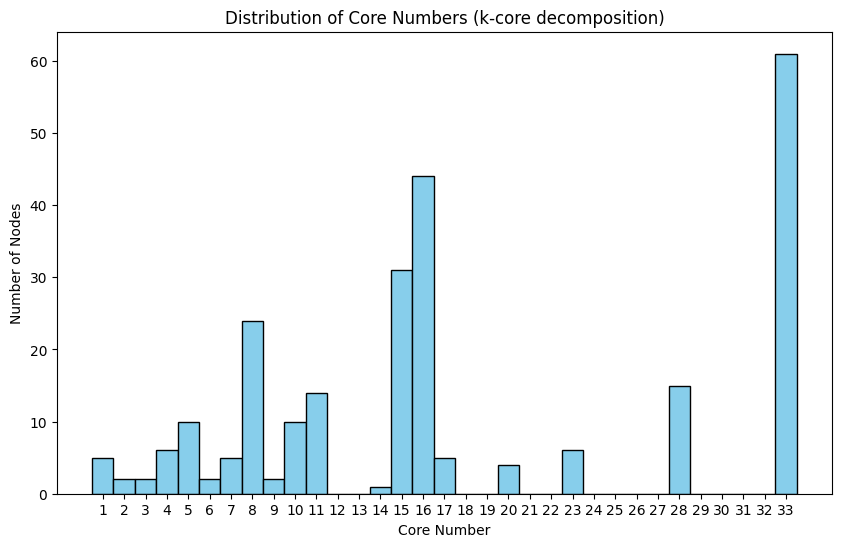

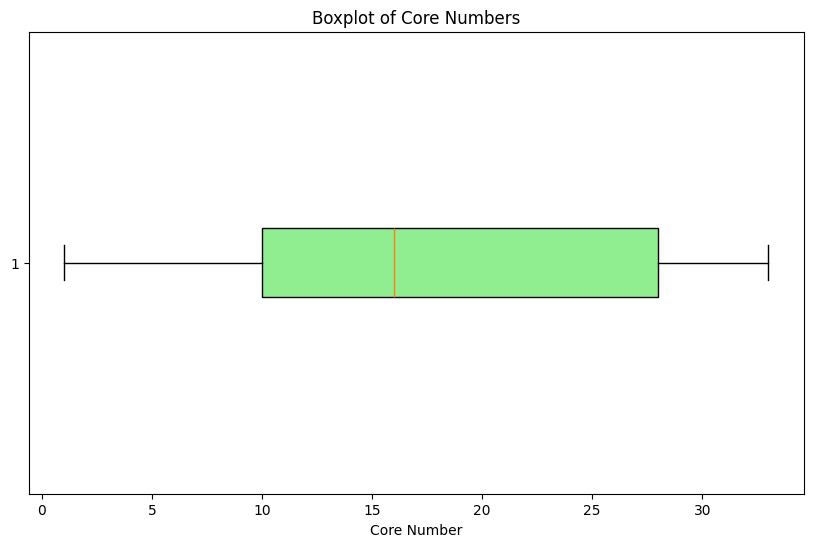

Mean core number: 18.15
Median core number: 16.00
Standard deviation: 10.20


In [469]:
plot_kcore_stats(G,'kcore')

Summary statistics:
           degree        core  clustering  betweenness   closeness
count  249.000000  249.000000  249.000000   249.000000  249.000000
mean    28.714859   18.148594    0.241146     0.005884    0.283399
std     24.048066   10.222426    0.285507     0.016846    0.178816
min      1.000000    1.000000    0.000000     0.000000    0.000000
25%     12.000000   10.000000    0.000000     0.000000    0.264957
50%     20.000000   16.000000    0.154589     0.000403    0.281818
75%     37.000000   28.000000    0.315958     0.002389    0.457565
max    118.000000   33.000000    0.975000     0.108313    0.566210


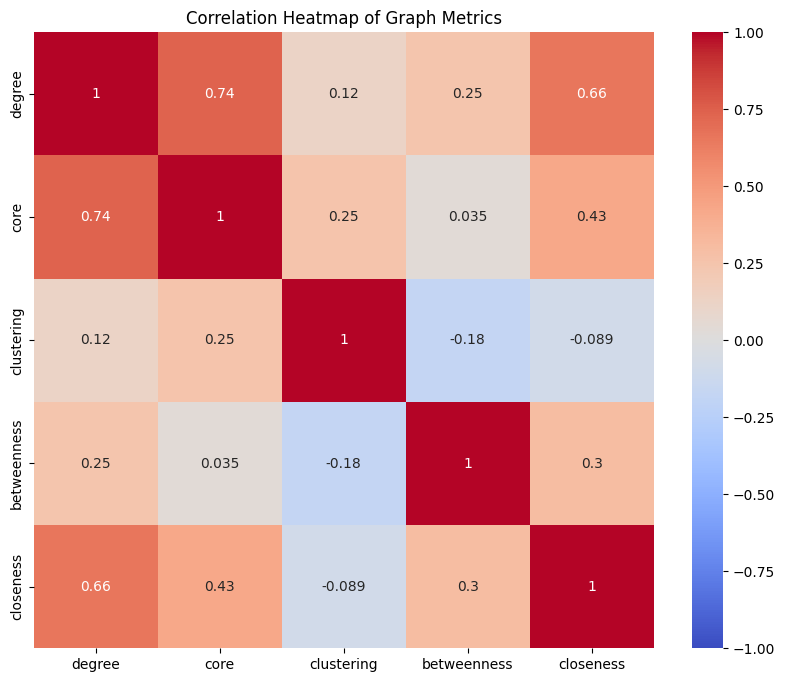

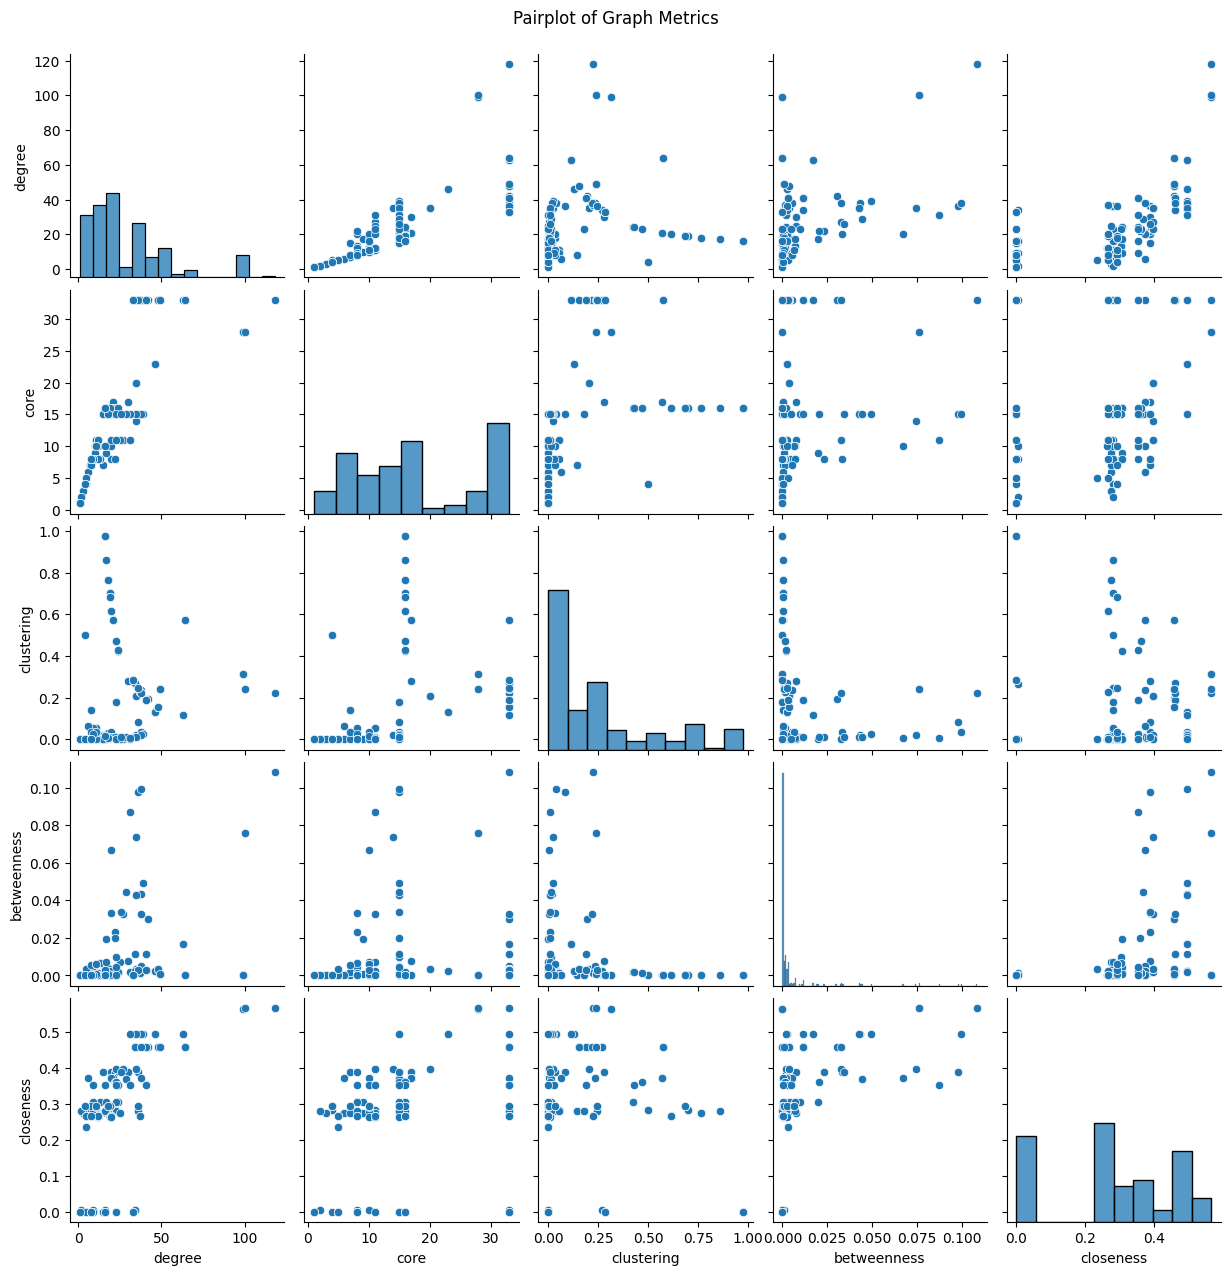

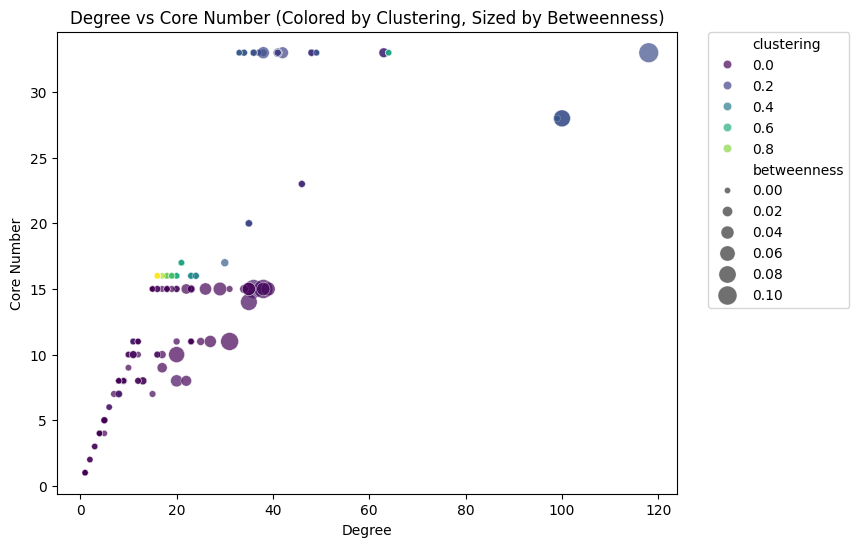

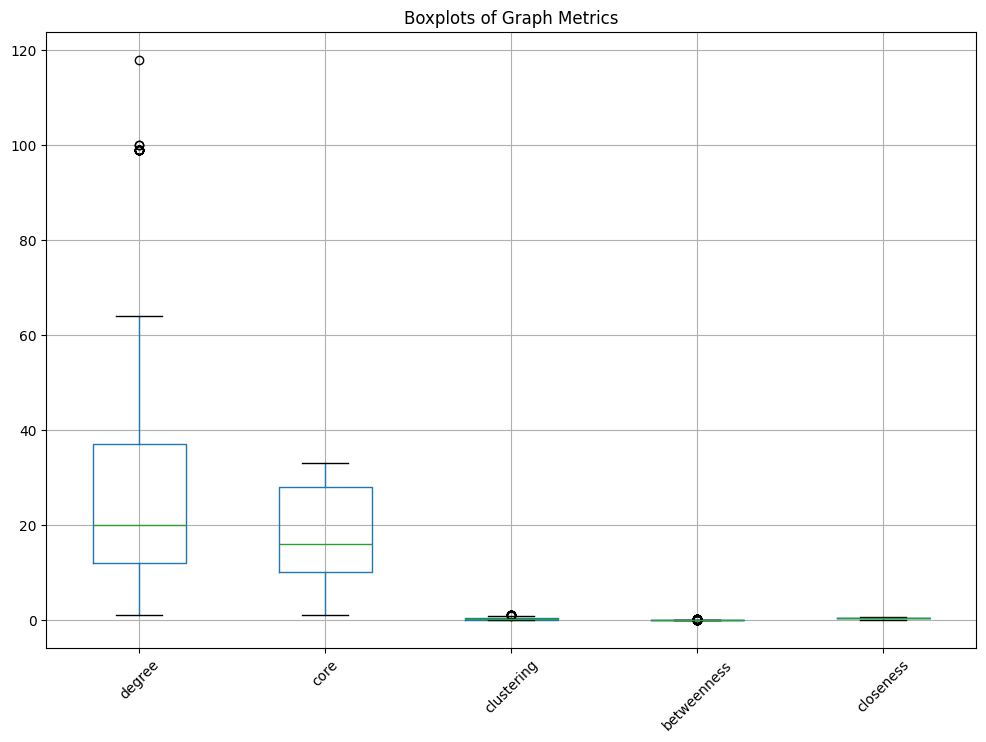

In [470]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Assuming G is your directed graph for the Atlas game.
# For some metrics, we'll work on the undirected version of G.
G_undirected = G.to_undirected()

# Compute node-level metrics
core_numbers = nx.core_number(G_undirected)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
clustering = nx.clustering(G_undirected)
degree_dict = dict(G.degree())

# Build a dictionary of metrics for each node
node_metrics = {}
for node in G.nodes():
    node_metrics[node] = {
        'degree': degree_dict[node],
        'core': core_numbers[node],
        'clustering': clustering[node],
        'betweenness': betweenness[node],
        'closeness': closeness[node]
    }

# Convert to a DataFrame
df = pd.DataFrame.from_dict(node_metrics, orient='index')
print("Summary statistics:")
print(df.describe())

# 1. Plot a correlation heatmap for the metrics
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Graph Metrics')
plt.show()

# 2. Create a pairplot to visualize distributions and relationships
sns.pairplot(df)
plt.suptitle("Pairplot of Graph Metrics", y=1.02)
plt.show()

# 3. Scatter plot: Degree vs. Core Number
plt.figure(figsize=(8, 6))
# Use clustering as color and betweenness to scale marker sizes
sns.scatterplot(data=df, x='degree', y='core', 
                hue='clustering', size='betweenness', sizes=(20, 200),
                palette='viridis', alpha=0.7)
plt.title("Degree vs Core Number (Colored by Clustering, Sized by Betweenness)")
plt.xlabel("Degree")
plt.ylabel("Core Number")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# 4. (Optional) Boxplots to see the distributions of each metric individually
plt.figure(figsize=(12, 8))
df.boxplot()
plt.title("Boxplots of Graph Metrics")
plt.xticks(rotation=45)
plt.show()


#### Analysis

### Bridges and hubs

In [442]:
hubs, authorities = nx.hits(G)
top_hubs = sorted(hubs.items(), key=lambda x: x[1], reverse=True)[:10]
top_auth = sorted(authorities.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Hub Nodes:", top_hubs)
print("Top 10 Authority Nodes:", top_auth)

Top 10 Hub Nodes: [('Bermuda', 0.011878006387741988), ('Bolivia', 0.011878006387741988), ('Bonaire, Sint Eustatius and Saba', 0.011878006387741988), ('Bosnia and Herzegovina', 0.011878006387741988), ('Botswana', 0.011878006387741988), ('Bulgaria', 0.011878006387741988), ('Cambodia', 0.011878006387741988), ('Canada', 0.011878006387741988), ('China', 0.011878006387741988), ('Colombia', 0.011878006387741988)]
Top 10 Authority Nodes: [('Afghanistan', 0.06307072517918882), ('Aland Islands', 0.06307072517918882), ('Azerbaijan', 0.06307072517918881), ('Algeria', 0.062368294189418166), ('American Samoa', 0.062368294189418166), ('Andorra', 0.062368294189418166), ('Antigua and Barbuda', 0.062368294189418166), ('Armenia', 0.062368294189418166), ('Aruba', 0.062368294189418166), ('Austria', 0.062368294189418166)]


In [452]:
bridges = list(nx.bridges(G.to_undirected()))
print(f"Bridges (Critical Edges): {bridges}")

Bridges (Critical Edges): [('British Indian Ocean Territory', 'Yemen'), ('Burkina Faso', 'Oman'), ('Jersey', 'Yemen'), ('Oman', 'Puerto Rico'), ('Paraguay', 'Yemen')]


#### Analysis

Hubs are Places that frequently start a new chain of locations.  
Authorities are Places that are frequently reached by other places.  
Bridges indicate one-way dependencies where certain transitions are unavoidable.  
Removing a bridge may create disconnected subgraphs in your Atlas game